In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Layer, concatenate, ReLU
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.layers import BatchNormalization
from scipy.stats import norm
from scipy.stats import zscore
from keras import backend
import tensorflow as tf

plt.rc('font', size=20)
plt.rcParams["font.family"] = "serif"

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [4]:
a = 0
s = 0

w_true = np.random.normal(-0.5,1,100000) #particle level data
w_reco = w_true #np.random.normal(-0.5, np.sqrt(1 + (a**2)*(s**2)), 100000) #detector level data
w_true_alt = np.random.normal(0,1,100000) #particle level simulation
w_reco_alt = w_true_alt#np.random.normal(0, np.sqrt(1 + (a**2)*(s**2)), 100000) #detector level simulation

In [5]:
# clip model weights to a given hypercube
class ClipConstraint(tf.keras.constraints.Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value
 
	# clip model weights to hypercube
	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)
 
	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}

const = ClipConstraint(0.01)


def weighted_wasserstein_loss(y_true, y_pred):
    weights = tf.gather(y_pred, [1], axis=1) # event weights
    y_pred = tf.gather(y_pred, [0], axis=1) # actual y_pred for loss
    
    weights_1 = K.sum(y_true*weights)
    weights_0 = K.sum((1-y_true)*weights)
    
    #tf.print("weights",weights_0,weights_1)
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = backend.mean(weights *y_true * y_pred)
    return K.mean(t_loss)

def weighted_gan_wasserstein_loss(y_true, y_pred):
    weights = tf.gather(y_pred, [1], axis=1) # event weights
    y_pred = tf.gather(y_pred, [0], axis=1) # actual y_pred for loss
    
    weights_1 = K.sum(y_true*weights)
    weights_0 = K.sum((1-y_true)*weights)
    
    #tf.print("weights",weights_0,weights_1)
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = backend.mean(weights *y_true * y_pred)
    return -1*K.mean(t_loss)

In [6]:
#generator
mymodel_inputtest_unifold = Input(shape=(1,))
hidden_layer_1_unifold = Dense(50, activation='ReLU',use_bias=True)(mymodel_inputtest_unifold)
batch_norm_1_unifold = BatchNormalization()(hidden_layer_1_unifold)
hidden_layer_2_unifold = Dense(50, activation='ReLU',use_bias=True)(batch_norm_1_unifold)
batch_norm_2_unifold = BatchNormalization()(hidden_layer_2_unifold)
hidden_layer_3_unifold = Dense(50, activation='ReLU',use_bias=True)(batch_norm_2_unifold)
outputs_unifold = tf.exp(Dense(1, activation='linear',use_bias=True)(hidden_layer_3_unifold))
model_generator_unifold = Model(mymodel_inputtest_unifold, outputs_unifold)

#discriminator
inputs_disc_unifold = Input((1, ))
hidden_layer_1_disc_unifold = Dense(50, activation='LeakyReLU', kernel_constraint=const)(inputs_disc_unifold)
batch_norm_1_disc_unifold = BatchNormalization()(hidden_layer_1_disc_unifold)
hidden_layer_2_disc_unifold = Dense(50, activation='LeakyReLU', kernel_constraint=const)(batch_norm_1_disc_unifold)
batch_norm_2_disc_unifold = BatchNormalization()(hidden_layer_2_disc_unifold)
hidden_layer_3_disc_unifold = Dense(50, activation='LeakyReLU', kernel_constraint=const)(batch_norm_2_disc_unifold)
outputs_disc_unifold = Dense(1, activation='linear')(hidden_layer_3_disc_unifold)
model_discrimantor_unifold = Model(inputs=inputs_disc_unifold, outputs=outputs_disc_unifold)

opt = tf.keras.optimizers.RMSprop(learning_rate=0.00005)

model_discrimantor_unifold.compile(loss=weighted_wasserstein_loss, optimizer=opt)

#GAN
model_discrimantor_unifold.trainable = False
mymodel_gan_unifold = Input(shape=(1,))
gan_model_unifold = Model(inputs=mymodel_gan_unifold,outputs=concatenate([model_discrimantor_unifold(mymodel_gan_unifold),model_generator_unifold(mymodel_gan_unifold)]))

gan_model_unifold.compile(loss=weighted_gan_wasserstein_loss, optimizer=opt)

In [7]:
xvals_1 = np.concatenate([w_true_alt,w_true])
yvals_1 = np.concatenate([np.ones(len(w_true_alt)),np.zeros(len(w_true))])

X_std = zscore(xvals_1)

X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(X_std, yvals_1)

n_epochs = 5
n_batch = 128*10
n_batches = len(X_train_1) // n_batch
n_critic = 5
losses = []

for i in range(n_epochs):
    mypreds = model_generator_unifold.predict(X_test_1,batch_size=1000)
    print("on epoch",i,np.mean(mypreds),np.min(mypreds),np.max(mypreds))
    for j in range(n_batches):
        
        for _ in range(n_critic):

            X_batch = X_train_1[j*n_batch:(j+1)*n_batch]
            Y_batch = Y_train_1[j*n_batch:(j+1)*n_batch]
            W_batch = model_generator_unifold(X_batch)
            W_batch = np.array(W_batch).flatten()
            W_batch[Y_batch==1] = 1
            #W_batch[Y_batch==0] = 1

            mypreds = model_generator_unifold.predict(X_batch,batch_size=1000)
            #print("     on batch=",j,np.mean(mypreds),np.min(mypreds),np.max(mypreds))

            Y_batch_2 = np.stack((Y_batch, W_batch), axis=1)
            model_discrimantor_unifold.train_on_batch(X_batch, Y_batch_2)
        
        losses += [gan_model_unifold.train_on_batch(X_batch[Y_batch==0],np.zeros(len(X_batch[Y_batch==0])))]

on epoch 0 0.9822868 0.6966539 1.1770343
on epoch 1 1.0077397 0.78008574 1.7324419
on epoch 2 1.0801876 0.76666397 2.9462855
on epoch 3 1.136331 0.6536729 3.500264
on epoch 4 1.0029609 0.42312986 1.9825363


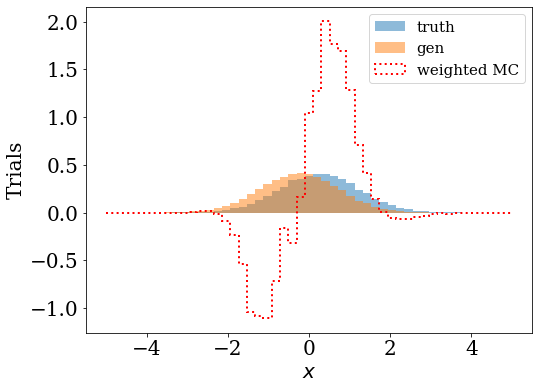

In [46]:
#bins = np.linspace(0,1,30)
mypreds = model_generator_unifold.predict(X_test_1,batch_size=1000)
fig, ax = plt.subplots(figsize=(8, 6))
bins = np.linspace(-5, 5)
_,_,_=plt.hist(X_test_1[Y_test_1==1],bins=bins,alpha=0.5,label="truth",density=True, zorder=-1)
_,_,_=plt.hist(X_test_1[Y_test_1==0],bins=bins,alpha=0.5,label="gen",density=True, zorder=0)
_,_,_=plt.hist(X_test_1[Y_test_1==0],bins=bins,weights=mypreds[Y_test_1==0],histtype="step",color="red",ls=":", lw=2,label="weighted MC",density=True, zorder=1)
plt.legend(fontsize=15)
plt.ylabel("Trials")
plt.xlabel("$x$")
#plt.savefig("Unifold.pdf", bbox_inches='tight', transparent=True)
plt.show()

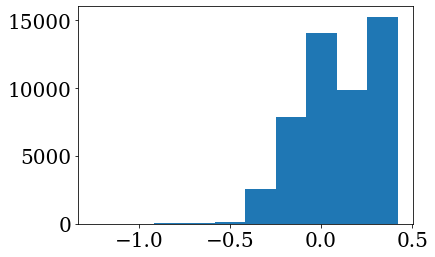

In [47]:
plt.hist(mypreds)
plt.show()

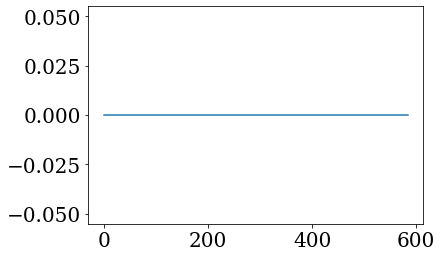

In [48]:
plt.plot(range(len(losses)), losses)
plt.show()